# Domača naloga 8
### Domen Gnidovec, 23212133

## Navodila

Z uporabo generatorja signalov in zajemnega sistema Arduino zajamite naključni signal s parametri (srednjo vrednostjo $m$, amplitudo $A$) iz podatkov naloge. Zajem podatkov izvedite tako, da boste pri pretvorbi zajetega signala v frekvnečno domeno dobili spekter na podanem frekvenčnem območju $[0, f_k]$ ter z ločljivostjo v frekvenčni domeni $\Delta f$ iz podatkov naloge.

Pripravite kratko poročilo v okolju Jupyter Notebook *(od 3 do 10 celic s kodo)*, v katerem naj bodo razvidni podatki naloge ter prikaz in kratek komentar naslednjih lastnosti zajetega signala:
* zajeto frekvenčno območje in frekvenčna ločljivost,
* ocena gostote porazdelitve verjetnosti vrednosti $p(x)$ zajetega signala $x(t)$,
* enostranska ter dvostranska avtospektralna gostota moči, $G_{XX}$ in $S_{XX}$,
* prvi štirje *spektralni* momenti ($m_0$, $m_1$, $m_2$, $m_3$) zajetega signala.

**Dodatek**: 
* Ovrednotite in komentirajte **stacionarnost** ter **ergodičnost** zgoraj generiranega naključnega signala (po potrebi zajamite dodatne signale, ki jih za to potrebujete).
* Numerično generirajte in komentirajte primera **nestacionarnega gaussovega** ter **stacionarnega ne-gaussovega** naključnega signala (glejte na primer [pyExSi](https://pypi.org/project/pyExSi/)).

In [3]:
# uvozimo knjiznice
import lvm_read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import pandas as pd
from scipy import signal

## Individualizirani parametri za generiranje signala
| Vpisna številka | $$m$$ | $$A_{pp}$$ | $$f_{k}$$ | $$\Delta f$$ |
| :-: | :-: | :-: | :-: | :-: |
| 23212133 | 2 | 1.5 | 33 | 0.25 |

## Zajem signala

In [67]:
# branje podatkov iz datoteke

path = 'signal.lvm'
data = lvm_read.read(path)

t = data[0]['data'][:, 0]
x = data[0]['data'][:, 1] 

In [68]:
# parametri

m = 2
A_pp = 1.5
f_k = 33
df = 0.25

fs = 2 * f_k # ustrezno frekvenčno območje
dt = 1 / fs # enako kot t[1]
N = 1 / (df * dt) # enako kot len(t)
T = 1 / df # enako kot N / fs - 4 sekunde

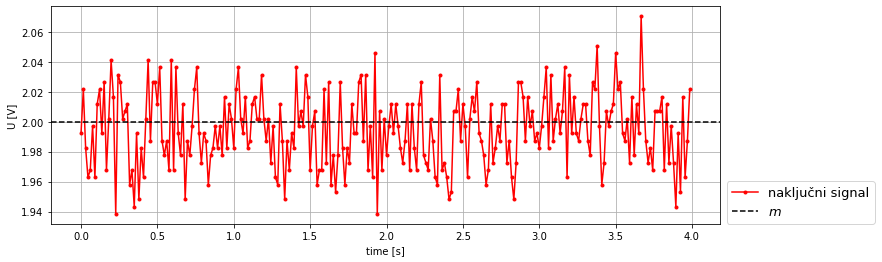

In [69]:
# graficni prikaz zajetega signala

plt.figure(figsize = (12, 4))
plt.plot(t, x, '-r.', lw=1.5, label="naključni signal")
plt.xlabel('time [s]')
plt.ylabel('U [V]')
plt.grid(True)
plt.axhline(y=m, c='k', ls='--', label='$m$')
plt.legend(fontsize=13, loc=(1.01,0));

## Frekvenčna domena

In [70]:
X = np.fft.rfft(x - m) / len(t)
X[1:] *= 2
freq = np.fft.rfftfreq(len(t), t[1])

### Spekter v podanem frekvenčnem območju $[0, f_{k}]$

Iz spodnjega spektra je razvidno, da je amplitudni spekter zajet ustrezno, nahaja se na območju od 0 Hz do 33 Hz. To smo dosegli z ustrezno frekvenco vzorčenja $f_{s} = 2 f_{k} = 66$.

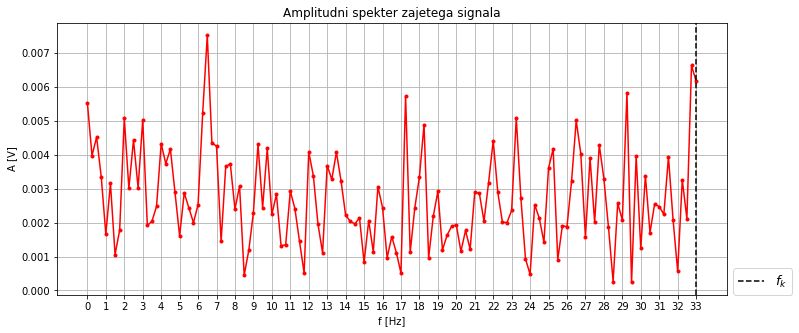

In [71]:
plt.figure(figsize = (12, 5))
plt.plot(freq, np.abs(X), '-r.')
plt.title('Amplitudni spekter zajetega signala')
plt.xlabel('f [Hz]')
plt.ylabel('A [V]')
plt.xticks(np.arange(0, f_k+1, 1))
plt.axvline(x=f_k, c='k', ls='--', label='$f_{k}$')
plt.legend(fontsize=13, loc=(1.01, 0))
plt.grid(True);

### Frekvenčna ločljivost $\Delta f$

Ustrezno frekvenčno ločljivost smo zagotovili z ustrezno dolžino signala oziroma številom zajetih točk, ki smo ga določili kot $N = \frac{1}{\Delta f \Delta t} = 264$. Na spodnjem grafu je podrobneje prikazan del spektra, da je jasno razvidna frekvenčna ločljivost.

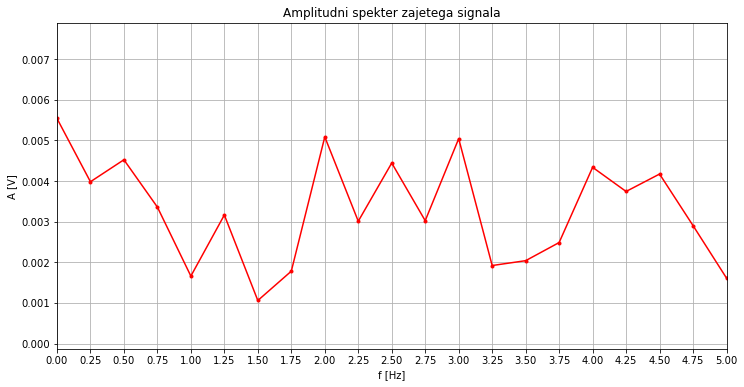

In [73]:
plt.figure(figsize = (12, 6))
plt.plot(freq, np.abs(X), '-r.')
plt.title('Amplitudni spekter zajetega signala')
plt.xlabel('f [Hz]')
plt.ylabel('A [V]')
plt.xticks(np.arange(0, 6, df)) # frekvenčna ločljivost
plt.xlim(0, 5)
plt.axvline(x=f_k, c='k', ls='--')
plt.grid(True);

## Ocena gostote porazdelitve verjetnosti vrednosti  $𝑝(𝑥)$

In [183]:
mean = sum(x)/N
deviations = [(i - mean) ** 2 for i in x]
s2 = sum(deviations) / N # varianca
s = np.sqrt(s2) # standardna deviacija

In [184]:
# gostota porazdelitve verjetnosti
p_x = 1/(s*np.sqrt(2*np.pi)) * np.exp(-(x-mean)**2/(2*s2))
p_p = scipy.stats.norm.pdf(x, mean, s)

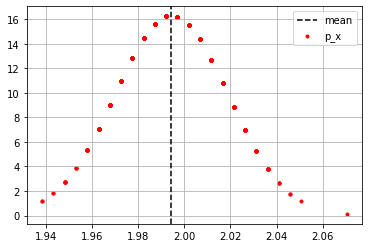

In [205]:
plt.scatter(x, p_x, c='r', marker='.', label='p_x')
plt.axvline(x=mean, c='k', ls='--', label='mean')
plt.grid(True)
plt.legend()
plt.show()

## Enostranska ter dvostranska avtospektralna gostota moči,  $𝐺_{𝑋𝑋}$  in  $𝑆_{𝑋𝑋}$

In [209]:
R_xx = np.correlate(x-mean, x-mean, mode='full') / s2 / N

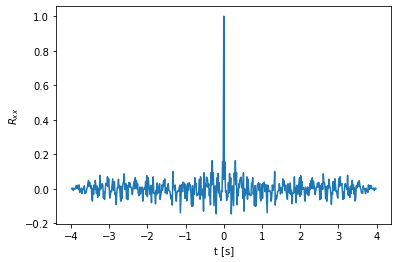

In [213]:
plt.plot(np.hstack([-t[::-1], t[1:]]), R_xx)
plt.xlabel('t [s]')
plt.ylabel('$R_{xx}$');

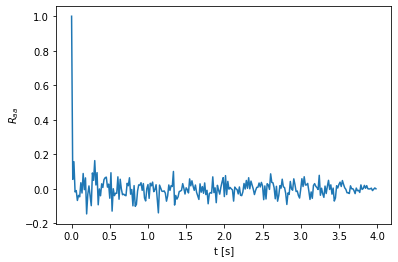

In [214]:
R_xx = R_xx[-len(x):]
plt.plot(t, R_xx)
plt.xlabel('t [s]')
plt.ylabel('$R_{aa}$');

In [232]:
S_xx_ = np.fft.rfft(R_xx) / len(R_xx) * 2 * T

A = np.fft.rfft(x) / len(x)
freq_xx = np.fft.rfftfreq(len(x), t[1])
S_xx = np.conj(A) * A  * 2 * T

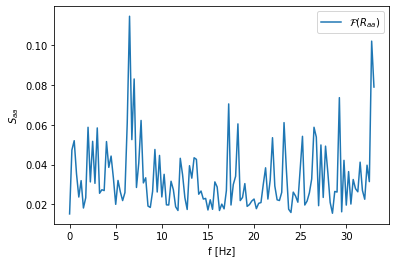

In [233]:
plt.plot(freq_xx, np.abs(S_xx_), label='$\mathcal{F}(R_{aa})$')
#plt.plot(freq_xx, np.abs(S_xx), label='$\mathcal{F}(A)* \cdot \mathcal{F}(A) / T$')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('$S_{aa}$');

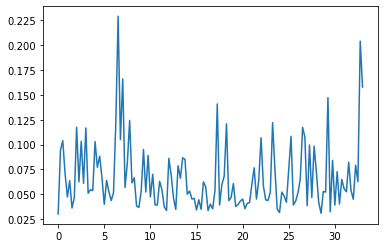

In [234]:
G_xx = 2 * S_xx_
plt.plot(freq_xx, np.abs(G_xx));

## Prvi štirje spektralni momenti ( $m_{0}, m_{1}, m_{2}, m_{3}$)

In [242]:
from scipy import integrate

mom = [integrate.trapz((2*np.pi*freq_xx)**i*G_xx) for i in range(4)] 

In [246]:
[print('m'+str(i), j) for i, j in enumerate(mom)];

m0 (8.000000000000002+0.038111374157677846j)
m1 (813.7383525399136+61.86663152799217j)
m2 (114250.55171192803+15196.193633159695j)
m3 (18177398.874999933+3133322.5280379825j)


## Dodatek

In [253]:
import pyExSi as es

ModuleNotFoundError: No module named 'pyExSi'

### Nestacionaren Gauss-ov signal

### Stacionaren neGauss-ov signal

In [260]:
pip install pyExSi

  Using cached pyExSi-0.43-py3-none-any.whl (10 kB)


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\astroid-2.5.dist-info\\COPYING'
Consider using the `--user` option or check the permissions.




  Using cached astroid-2.6.6-py3-none-any.whl (231 kB)
  Attempting uninstall: astroid
    Found existing installation: astroid 2.5
    Uninstalling astroid-2.5:


In [261]:
import pyExSi as es

ModuleNotFoundError: No module named 'pyExSi'